In [294]:
import random
import matplotlib.pyplot as plt

In [295]:
def objective_function(vector):
    v = 0.0
    for i in vector:
        v = v + i ** 2.0
    return v

In [296]:
def create_search_space(problem_size):
    ss = list()
    for i in range(problem_size):
        ss.append([-5, 5])
    return ss

In [297]:
def rand_in_bounds(min, max):
    return min + ((max-min) * random.random())

In [298]:
def random_vector(minmax):
    vector = list()
    for i in range(len(minmax)):
        rand = rand_in_bounds(minmax[i][0], minmax[i][1])
        vector.append(rand)
    return vector

In [299]:
def mutate_with_inf(candidate, beliefs, minmax):
    v = list()
    for i in range(len(candidate["vector"])):
        x = rand_in_bounds(beliefs["normative"][i][0], beliefs["normative"][i][1])
        if x < minmax[i][0]: x = minmax[i][0]
        if x > minmax[i][1]: x = minmax[i][1]
        v.append(x)
    return {"vector": v}

In [300]:
def binary_tournament(pop_size, contestants, elites):
    new_population = list()
    # keep top contestants
    contestants.sort(key = lambda c: c["fitness"])
    for i in range(elites):
        survivor = contestants.pop(0)
        new_population.append(survivor)
    # select two different contestants
    for i in range(pop_size):
        c1 = random.randint(0, len(contestants)-1)
        c2 = random.randint(0, len(contestants)-1)
        while c1 == c2:
            c2 = random.randint(0, len(contestants)-1)
        # take the better of the two
        if contestants[c1]["fitness"] < contestants[c2]["fitness"]:
            survivor = contestants.pop(c1)
        else:
            survivor = contestants.pop(c2)
        new_population.append(survivor)
    return new_population

In [301]:
def initialize_population(pop_size, search_space):
    population = list()
    for i in range(pop_size):
        d = {"vector": random_vector(search_space)}
        population.append(d)
    return population

In [302]:
def initialize_beliefspace(search_space):
    belief_space = {}
    belief_space["situational"] = None
    belief_space["normative"] = list()
    for i in range(len(search_space)):
        belief_space["normative"].append(list(search_space[i]))
    return belief_space

In [303]:
def update_beliefspace_situational(belief_space, best):
    curr_best = belief_space["situational"]
    if curr_best is None or best["fitness"] < curr_best["fitness"]:
        belief_space["situational"] = best

In [304]:
def update_beliefspace_normative(belief_space, acc):
    for i in range(len(belief_space["normative"])):
        acc_min = min(acc, key = lambda v: v["vector"][i])
        belief_space["normative"][i][0] = acc_min["vector"][i]
        acc_max = max(acc, key = lambda v: v["vector"][i])
        belief_space["normative"][i][1] = acc_max["vector"][i]

In [305]:
def cultural_search(max_gens, search_space, pop_size, num_accepted, elites):
    # initialize
    population = initialize_population(pop_size, search_space)
    belief_space = initialize_beliefspace(search_space)
    fitness_data = list()
    
    # evaluate
    for c in population:
        c["fitness"] = objective_function(c["vector"])
        
    # get current best
    best = min(population, key = lambda c: c["fitness"])
    
    # update situational knowledge
    update_beliefspace_situational(belief_space, best)
    
    # add situational_belief to fitness_data
    fitness_data.append(best["fitness"])
    
    # evolution:
    for gen in range(max_gens):
        # create new generation
        children = list()
        for c in range(pop_size):
            new_child = mutate_with_inf(population[c], belief_space, search_space)
            children.append(new_child)

        # evaluate new generation
        for c in children:
            c["fitness"] = objective_function(c["vector"])
        
        # survivor selection
        population = binary_tournament(pop_size, children + population, elites)
        
        # get new current best
        best = min(population, key = lambda c: c["fitness"])
        
        # update situational knowledge
        update_beliefspace_situational(belief_space, best)
        
        # add situational_belief to fitness_data
        fitness_data.append(best["fitness"])
        
        # update normative knowledge
        population.sort(key = lambda c: c["fitness"])
        acccepted = population[:num_accepted]
        update_beliefspace_normative(belief_space, acccepted)
            
    return belief_space["situational"], fitness_data

In [306]:
def mutate(candidate, solution_space, mutation_rate):
    new_vector = list()
    for i in range(len(candidate["vector"])):
        new_vector.append(candidate["vector"][i])
    genes = 1 # random.randint(0, round(len(candidate["vector"]) * mutation_rate))
    gene_hist = list()
    for i in range(genes):
        indx = random.randint(0, len(solution_space)-1)
        while indx in gene_hist:
            indx = random.randint(0, len(solution_space)-1)
        gene_hist.append(indx)
        new_vector[indx] = rand_in_bounds(solution_space[indx][0], solution_space[indx][1])
    return {"vector": new_vector}

In [307]:
def evolutionary_search(max_gens, search_space, pop_size, elites):
    # initialize
    population = initialize_population(pop_size, search_space)
    fitness_data = list()
    
    # evaluate
    for c in population:
        c["fitness"] = objective_function(c["vector"])
    
    # get current best
    best = min(population, key = lambda c: c["fitness"])
    
    # add best to fitness_data
    fitness_data.append(best["fitness"])
    
    # evolution:
    for gen in range(max_gens):
        # create new generation
        children = list()
        for c in range(pop_size):
            new_child = mutate(population[c], search_space, 0.5)
            children.append(new_child)

        # evaluate new generation
        for c in children:
            c["fitness"] = objective_function(c["vector"])
        
        # survivor selection
        population = binary_tournament(pop_size, children + population, elites)
        
        # get new current best
        best = min(population, key = lambda c: c["fitness"])
        
        # add best to fitness_data
        fitness_data.append(best["fitness"])
        
    # get new current best
    best = min(population, key = lambda c: c["fitness"])
    
    return best, fitness_data

In [308]:
def random_search(max_gens, search_space, pop_size, elites):
    # initialize
    population = initialize_population(pop_size, search_space)
    fitness_data = list()
    
    # evaluate
    for c in population:
        c["fitness"] = objective_function(c["vector"])
    
    # get current best
    best = min(population, key = lambda c: c["fitness"])
    
    # add best to fitness_data
    fitness_data.append(best["fitness"])
    
    # evolution:
    for gen in range(max_gens):
        # create new generation
        children = list()
        for c in range(pop_size):
            new_child = {"vector": random_vector(search_space)}
            children.append(new_child)

        # evaluate new generation
        for c in children:
            c["fitness"] = objective_function(c["vector"])
        
        # survivor selection
        population = binary_tournament(pop_size, children + population, elites)
        
        # get new current best
        best = min(population, key = lambda c: c["fitness"])
        
        # add best to fitness_data
        fitness_data.append(best["fitness"])
        
    # get new current best
    best = min(population, key = lambda c: c["fitness"])
    
    return best, fitness_data

In [309]:
def plot_fitness(data, max_val):
    x = list(range(len(data)))
    y = data
    graph = plt.gca()
    graph.set_ylim([0,max_val])
    plt.ylabel("Fitness")
    plt.xlabel("Iteration")
    graph.plot(x, y)
    plt.show()

In [341]:
def plot_compare_self(data_sets, title):
    # get max y-val
    all_data = list()
    for ds in data_sets:
        all_data = all_data + ds["fitness_data"]
    max_val = max(all_data)
    
    graph = plt.gca()
    graph.set_ylim([0,max_val])
    plt.title(title)
    plt.ylabel("Fitness")
    plt.xlabel("Iteration")
    
    for i in range(len(data_sets)):
        ds = data_sets[i]
        trial = "Trial " + str(i+1)
        print(trial + " Solution: f= " + str(ds["best"]["fitness"]))
        x = list(range(len(ds["fitness_data"])))
        y = ds["fitness_data"]
        graph.plot(x, y, label=trial)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [342]:
def plot_compare_algorithms(data_sets, max_val):
    graph = plt.gca()
    graph.set_ylim([0,max_val])
    plt.ylabel("Fitness")
    plt.xlabel("Iteration")

    # plot cultural
    xc = list(range(len(data_sets[0])))
    yc = data_sets[0]
    graph.plot(xc, yc, label="Cultural", color="green")
    
    # plot evolutionary
    xe = list(range(len(data_sets[1])))
    ye = data_sets[1]
    graph.plot(xe, ye, label="Evolutionary", color="orange")
    
    # plot random
    xr = list(range(len(data_sets[2])))
    yr = data_sets[2]
    graph.plot(xr, yr, label="Random", color="red")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

Cultural Solution:     f= 3.580429343537928e-38
Evolutionary Solution: f= 0.1721735216331355
Random Solution:       f= 7.377309611844737


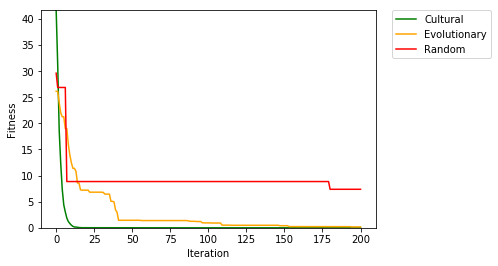

Trial 1 Solution: f= 2.4943911568805293e-36
Trial 2 Solution: f= 3.580429343537928e-38
Trial 3 Solution: f= 0.001188397017731802
Trial 4 Solution: f= 3.488601310514183e-17
Trial 5 Solution: f= 3.2147963747119285e-14


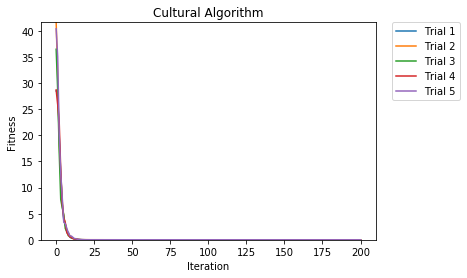

Trial 1 Solution: f= 0.1721735216331355
Trial 2 Solution: f= 0.659822511991087
Trial 3 Solution: f= 0.37609028045177806
Trial 4 Solution: f= 0.17508227888589223
Trial 5 Solution: f= 0.5051620203423455


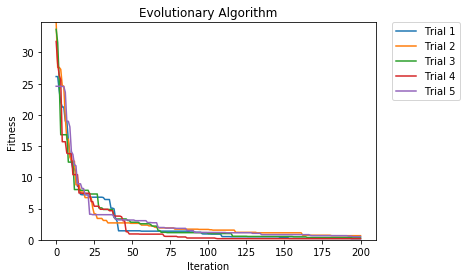

Trial 1 Solution: f= 13.115121737221106
Trial 2 Solution: f= 8.001983476520747
Trial 3 Solution: f= 10.15597158295907
Trial 4 Solution: f= 7.377309611844737
Trial 5 Solution: f= 12.940964065488131


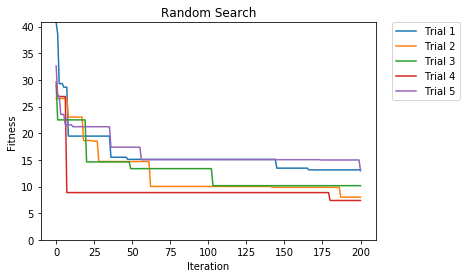

In [351]:
if __name__ == "__main__":
    # problem configuration
    problem_size = 10
    search_space = create_search_space(problem_size)
    
    # algorithm configuration
    trial_runs = 5
    max_gens = 200
    pop_size = 100
    num_accepted = round(pop_size * 0.20)
    elites = 1
    
    # execute the cultural algorithm
    cultural_runs = list()
    for i in range(trial_runs):
        best, fitness_data = cultural_search(max_gens, search_space, pop_size, num_accepted, elites)
        cultural_runs.append({"best": best, "fitness_data": fitness_data})
    c_best_run = min(cultural_runs, key = lambda r: r["best"]["fitness"])
    c_best = c_best_run["best"]
    c_fitness_data = c_best_run["fitness_data"]
    c_best_fitness = c_best["fitness"]
    c_best_vector = c_best["vector"]
    
    # execute the evolutionary algorithm
    evolutionary_runs = list()
    for i in range(trial_runs):
        best, fitness_data = evolutionary_search(max_gens, search_space, pop_size, num_accepted, elites)
        evolutionary_runs.append({"best": best, "fitness_data": fitness_data})
    e_best_run = min(evolutionary_runs, key = lambda r: r["best"]["fitness"])
    e_best = e_best_run["best"]
    e_fitness_data = e_best_run["fitness_data"]
    e_best_fitness = e_best["fitness"]
    e_best_vector = e_best["vector"]
    
    # execute the random algorithm
    random_runs = list()
    for i in range(trial_runs):
        best, fitness_data = random_search(max_gens, search_space, pop_size, num_accepted, elites)
        random_runs.append({"best": best, "fitness_data": fitness_data})
    r_best_run = min(random_runs, key = lambda r: r["best"]["fitness"])
    r_best = r_best_run["best"]
    r_fitness_data = r_best_run["fitness_data"]
    r_best_fitness = r_best["fitness"]
    r_best_vector = r_best["vector"]
    
    # plot the data
    all_vals = c_fitness_data + e_fitness_data + r_fitness_data
    max_val = max(all_vals)
    
    # plot all together
    print("Cultural Solution:     f= " + str(c_best_fitness))
    print("Evolutionary Solution: f= " + str(e_best_fitness))
    print("Random Solution:       f= " + str(r_best_fitness))
    all_data_sets = [c_fitness_data, e_fitness_data, r_fitness_data]
    plot_fitness_compare(all_data_sets, max_val)
    
    plot_compare_self(cultural_runs, "Cultural Algorithm")
    plot_compare_self(evolutionary_runs, "Evolutionary Algorithm")
    plot_compare_self(random_runs, "Random Search")